In [24]:
import osmnx as ox
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS, Transformer

In [61]:
def get_india_states():
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    aoi_dir = os.path.join(parent_dir, "aoi")

    india_path = os.path.join(aoi_dir, "india1.json")
    india_states = gpd.read_file(india_path)
    return india_states


def calculate_distance(row, point):
    centroid_utm = row["centroid"]
    distance = centroid_utm.distance(Point(point))
    return distance


def drop_duplicated_lakes(gdf):
    idx = gdf.groupby("osmid")["distance"].idxmin()
    filtered_lakes = gdf.loc[idx]

    # Resetear el índice del DataFrame resultante
    filtered_lakes = filtered_lakes.reset_index(drop=True)
    return filtered_lakes


def plot_indian_lakes(universities, lakes):
    india_states = get_india_states()
    universities["geometry"] = universities.apply(
        lambda row: Point(row["longitude"], row["latitude"]), axis=1
    )
    universities_gdp = gpd.GeoDataFrame(universities, geometry="geometry")

    _, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Plotear el mapa base de la India
    india_states.plot(ax=ax, color="lightgrey", edgecolor="black")
    lakes["centroid_ws"].plot(ax=ax, color="blue", markersize=20, label="Lakes")

    universities_gdp.plot(ax=ax, color="red", markersize=20, label="Universities")
    plt.legend()

    # Añadir título
    plt.title("Lakes and Universities from India")

    # Mostrar el plot
    plt.show()


def get_lakes(
    longitude: float, latitude: float, distance: int, area: int = 1000000
) -> gpd.GeoDataFrame:

    tags = {"natural": "water"}  # Searching for natural water bodies

    waterbodies = ox.features_from_point(
        (latitude, longitude), tags=tags, dist=distance
    )
    allowed_values = ["pond", "reservoir", "lake", "basin"]
    if 'water' not in waterbodies.columns:
        columns = ["name", "geometry_long_lat", "area", "centroid_ws"]
        return pd.DataFrame(columns=columns)
    lakes = waterbodies[waterbodies["water"].isin(allowed_values)]
    if 'name' not in lakes.columns:
        lakes['name'] = None
    lakes = lakes[["name", "geometry", "water"]]

    # Ensure geometries are valid and not empty
    lakes = lakes[lakes["geometry"].notna()]
    lakes = lakes[lakes.geometry.is_valid]

    # Add centroid coordinates
    lakes["geometry_long_lat"] = lakes["geometry"]

    # Determine the appropriate UTM zone and reproject
    zone_number = int((longitude + 180) / 6) + 1
    utm_crs = CRS(f"EPSG:326{zone_number}")
    lakes = lakes.to_crs(utm_crs)

    transformer = Transformer.from_crs("EPSG:4326", utm_crs, always_xy=True)
    reference_point_utm = transformer.transform(longitude, latitude)

    lakes["area"] = lakes.geometry.area
    lakes["centroid"] = lakes.geometry.centroid

    lakes = lakes.sort_values(by="area", ascending=False)
    lakes["distance"] = lakes.apply(
        calculate_distance, axis=1, point=reference_point_utm
    )
    lakes["centroid_ws"] = lakes["centroid"].to_crs(epsg=4326)

    lakes = lakes[lakes["area"] > area]

    lakes = lakes[["name", "geometry_long_lat", 'distance', "area", "centroid_ws"]]
    lakes = lakes.reset_index()
    return lakes


def get_all_lakes(df, distance, area=1000000, drop_duplicated=True):
    dataframes = []
    for i, row in df.iterrows():
        print(i)
        longitude = row["longitude"]
        latitude = row["latitude"]
        university_lakes = get_lakes(longitude, latitude, distance, area)
        dataframes.append(university_lakes)
        university_lakes["point name"] = row["name"]

    all_lakes = pd.concat(dataframes, ignore_index=True)
    all_lakes = all_lakes.sort_values(by="area", ascending=False)
    plot_indian_lakes(df, all_lakes, distance, area)
    if drop_duplicated == True:
        return drop_duplicated_lakes(all_lakes)
    return all_lakes

In [51]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

universities_path = os.path.join(data_dir, 'Universities.csv')
universities = pd.read_csv(universities_path, encoding='ISO-8859-1')

In [52]:
universities = universities[['name', 'longitude', 'latitude']]

In [60]:
first50_universities = universities.head(50)

C:\Users\agand\AppData\Local\Temp\ipykernel_10668\2919099164.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  universities["geometry"] = universities.apply(


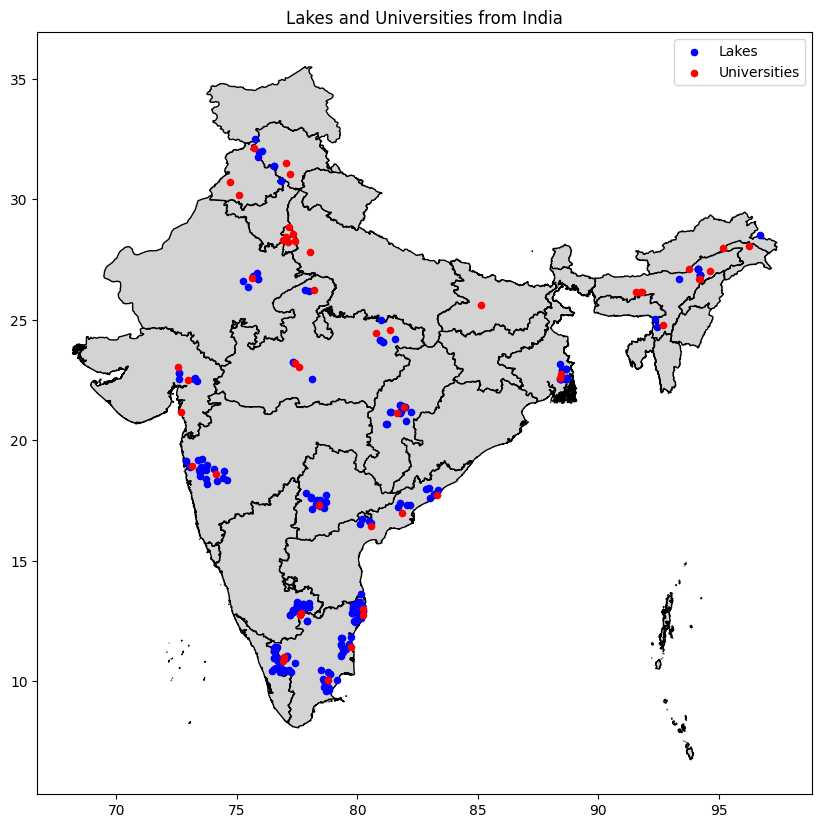

In [62]:
first50_all_lakes = get_all_lakes(first50_universities, 50000, area = 800000)

In [64]:
first50_all_lakes

,element_type,osmid,name,geometry_long_lat,area,centroid_ws,point name
171,relation,1624070,Pulicat Lake,"POLYGON ((80.06663 13.74198, 80.06645 13.74231...",5.605353e+08,POINT (80.16098 13.63083),Anna University
78,relation,16288976,Ban Sagar Lake,"POLYGON ((80.81554 23.97029, 80.81554 23.96996...",2.964632e+08,POINT (81.05000 24.08555),AKS University
251,relation,16288976,Ban Sagar Lake,"POLYGON ((80.81554 23.97029, 80.81554 23.96996...",2.964632e+08,POINT (81.05000 24.08555),Awadesh Pratap Singh University
216,relation,332072,Maharana Pratap Reservoir,"POLYGON ((75.97166 32.01921, 75.97037 32.02155...",2.326225e+08,POINT (76.05455 31.99650),Arni University
38,relation,7876724,Singur Lake,"POLYGON ((77.76814 17.91808, 77.76764 17.91721...",1.332459e+08,POINT (77.86235 17.82761),Acharya Ng Ranga Agricultural University
...,...,...,...,...,...,...,...
202,way,102302994,NaN,"POLYGON ((80.02056 12.86987, 80.02110 12.87000...",8.306171e+05,POINT (80.02618 12.87521),Anna University
116,relation,2310417,Madivala Lake,"MULTIPOLYGON (((77.61148 12.90258, 77.61153 12...",8.284080e+05,POINT (77.61633 12.90649),Alliance University
281,relation,2310417,Madivala Lake,"MULTIPOLYGON (((77.61148 12.90258, 77.61153 12...",8.284080e+05,POINT (77.61633 12.90649),Azim Premji University
213,way,386121032,NaN,"POLYGON ((79.30499 11.50276, 79.30544 11.50319...",8.061982e+05,POINT (79.31068 11.50823),Annamalai University
